# **MSIN0097 Predictive Analytics: Individual Coursework**

# **Predicting Stock Prices with Neural Networks**

### **Word Count: 1984**

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Exploration & Preprocessing](#Data-Exploration-Preprocessing)
3. [Simple Model: ARIMA](#ARIMA)
4. [Feature Engineering](#Feature-Engineering)
5. [Ensemble Model: Random Forest](#Random-Forest)
6. [Neural Network: RNN](#Neural-Network)
7. [Conclusion](#Conclusion)
8. [Appendix](#Appendix)
9. [Repository Link](#Link)

## 0. Notebook Set-Up

In [1]:
## Importing relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
## Installing relevant packages
!pip install --upgrade ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=2f3a00c19c95b5218fbbf1408fcc35d52061e724032b7b5667eac19d7ac0b315
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
## Set random seed
np.random.seed(42)

<a id="Introduction"></a>
## 1. Introduction

Stock price speculation is the bread and butter for investors entering the market with the intention of making a profit trading stocks. Will it go up? Will it go down? Should I buy or should I sell? The financial industry has dedicated substantial amounts of time, resources and brainpower deriving ways to foretell the future of the market. The result of this labour: two differing methods. The first, fundamental analysis, investigates a company's business practices, corporate management and financial statements to value a stock representatively. The second, technical analysis, utilises statistical methods to forecast future prices based on trends and patterns identified in historical prices (Bohl, 2024). Unlike fundamental analysis, which adheres strictly to financial frameworks carefully laid out by academics, technical analysis’ data-driven approach presents the perfect opportunity to integrate state-of-the-art machine learning techniques.


Therefore, in this project, I experimented with different machine learning models, most notably neural networks, to predict Alphabet’s stock price based on its historical prices. I began by defining a benchmark ARIMA model before moving onto a random forest regressor, both of which informed the creation and fine-tuning of a final recurrent neural network.

<a id="Data-Exploration-Preprocessing"></a>
## 2. Data Exploration & Preprocessing

### The Dataset

Alphabet currently offers two types of common stock: class A (trading as GOOGL), which grants shareholders voting rights, and class C (GOOG), which does not. I have used class A GOOGL stock, as this is more commonly bought by investors (Duggan, 2024).

I downloaded ten years of historical GOOGL stock prices (20-03-2014 to 20-03-2024) from Yahoo Finance. The important column to note is adjusted close (‘Adj Close’), which is the ‘price’ variable of interest. Given that it already accounts for all the other columns (different price variables and volume) in its calculation, I omitted them from my dataset during modelling. However, I did use them for feature engineering. Please refer to Appendix B for more information on each column in the dataset.

In [3]:
## Importing data
df_company_returns = pd.read_csv('GOOGL.csv')

In [5]:
## Viewing the time series historical returns data
df_company_returns.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,20/03/2014,30.028778,30.270521,29.913914,29.958960,29.958960,67320612
1,21/03/2014,30.187939,30.271021,29.590841,29.605606,29.605606,128211660
2,24/03/2014,29.634384,29.652151,28.677427,28.977226,28.977226,121362516
3,25/03/2014,29.179178,29.275274,28.703705,28.996998,28.996998,96311592
4,26/03/2014,29.079329,29.318569,28.315817,28.327578,28.327578,103096800


In [6]:
## Viewing additional data
df_company_returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2518 non-null   object 
 1   Open       2518 non-null   float64
 2   High       2518 non-null   float64
 3   Low        2518 non-null   float64
 4   Close      2518 non-null   float64
 5   Adj Close  2518 non-null   float64
 6   Volume     2518 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


In [7]:
# Change date to date-time
df_company_returns['Date'] = pd.to_datetime(df_company_returns['Date'], dayfirst=True)

In [8]:
# For now, we only need the adjusted close price
google_price = df_company_returns.drop(columns = ['Close', 'Open', 'High', 
                                                  'Low', 'Volume'], axis = 1)

### Train/ Validation/ Test Split

I opted to split based on years to preserve the temporal order of the data. Allocating 8 years to training, 1 year to validation and the final year to testing gave me a desirable 80% train, 10% validation and 10% test division (Radečić, 2022).

In [9]:
## Split time series
test_googl = google_price[google_price['Date'] >= '2023-03-20']
val_googl = google_price[(google_price['Date'] < '2023-03-20') & 
                         (google_price['Date'] >= '2022-03-20')]
train_googl = google_price[google_price['Date'] < '2022-03-20']

In [10]:
# Check length of data
print("Number of observations in test_googl:", len(test_googl))
print("Number of observations in val_googl:", len(val_googl))
print("Number of observations in train_googl:", len(train_googl))

Number of observations in test_googl: 253
Number of observations in val_googl: 250
Number of observations in train_googl: 2015


### Exploratory Data Analysis

To understand the data, I calculated summary statistics and made various time-series plots.

In [ ]:
## Viewing summary statistics
train_googl['Adj Close'].describe()

count    2015.000000
mean       60.094165
std        32.207384
min        24.853001
25%        37.255249
50%        52.873501
75%        68.686500
max       149.838501
Name: Adj Close, dtype: float64

In [ ]:
## Group some summary stats by financial quarters
quarterly_stats = train_googl.resample('Q').agg({'Adj Close': ['mean', 'std', 'min', 'max']})
print (quarterly_stats)

             Adj Close                                  
                  mean       std         min         max
Date                                                    
2014-03-31   28.709210  0.799480   27.884886   29.958960
2014-06-30   27.613715  0.904501   25.900000   29.296499
2014-09-30   29.468352  0.425837   28.590500   30.270000
2014-12-31   27.315696  0.920113   24.908001   29.389000
2015-03-31   27.088828  1.176504   24.853001   29.071501
2015-06-30   27.468405  0.383390   26.636999   28.683001
2015-09-30   32.194211  2.183331   27.084999   34.980999
2015-12-31   37.007719  2.023345   32.099998   39.698002
2016-03-31   36.814426  1.004585   35.050999   39.045502
2016-06-30   36.700602  1.249815   34.056999   39.383999
2016-09-30   39.109649  1.567226   35.244499   40.797501
2016-12-31   39.983341  0.899803   37.660999   41.786999
2017-03-31   42.048790  0.791840   40.388500   43.618500
2017-06-30   46.775151  2.662034   41.993999   50.214001
2017-09-30   47.428302  0.92557

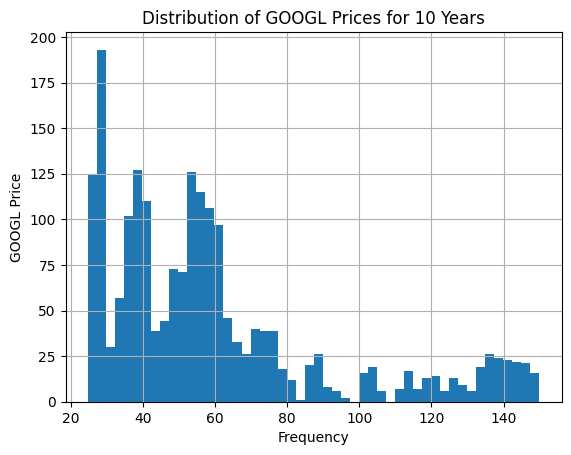

In [ ]:
## Plotting the distribution of adj close
train_googl['Adj Close'].hist(bins = 50)
plt.title('Distribution of GOOGL Prices for 10 Years')
plt.xlabel('Frequency')
plt.ylabel('GOOGL Price')
plt.show()

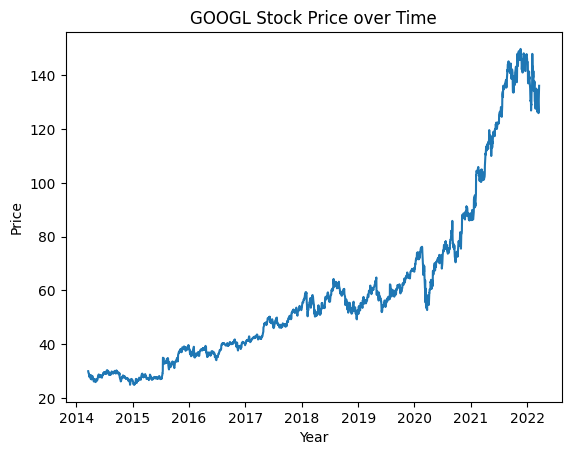

In [ ]:
## Plotting google's stock price over time
plt.plot(train_googl['Date'], train_googl['Adj Close'])
plt.title('GOOGL Stock Price over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

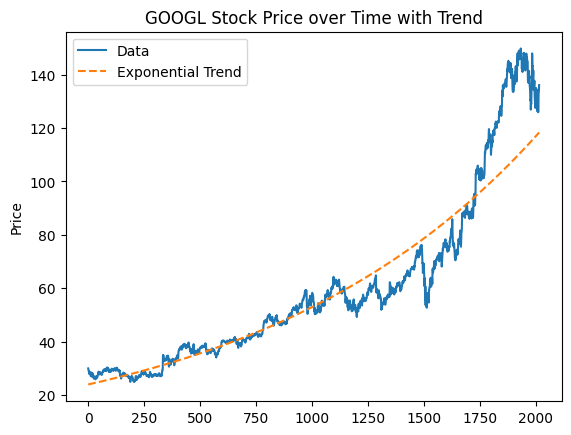

In [ ]:
## Fitting a basic exponential trendline
time_index = range(len(train_googl['Date']))

# Plot original data
plt.plot(time_index, train_googl['Adj Close'], label='Data')

# Fit and plot exponential trend
fit = np.polyfit(time_index, np.log(train_googl['Adj Close']), 1)
fitted_trend = np.exp(fit[1]) * np.exp(fit[0] * time_index)
plt.plot(time_index, fitted_trend, label='Exponential Trend', linestyle='--')

plt.title('GOOGL Stock Price over Time with Trend')
plt.ylabel('Price')
plt.legend()
plt.show()

GOOGL’s price generally increases following a nonlinear, possibly exponential trend. Thus, I used a multiplicative model for decomposition. Periods are set to 60 days to coincide with financial quarters.

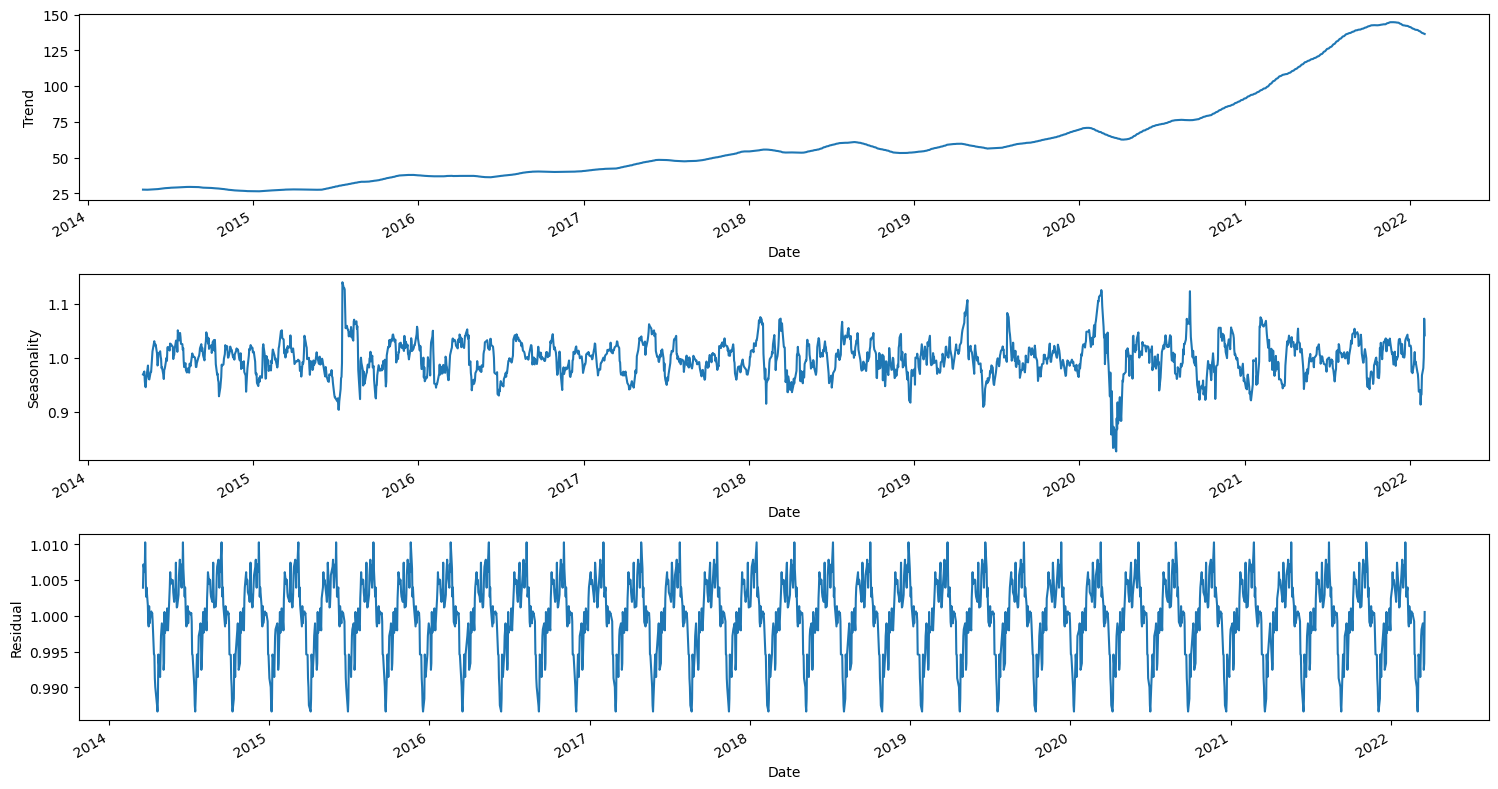

In [ ]:
## Decompose time-series trends
from statsmodels.tsa.seasonal import seasonal_decompose

# setting period to 1/4 of a year (~60 trading days)
res = seasonal_decompose(train_googl, model = "multiplicative", period = 60)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))

res.trend.plot(ax=ax1,ylabel = "Trend")
res.resid.plot(ax=ax2,ylabel = "Seasonality")
res.seasonal.plot(ax=ax3,ylabel = "Residual")
plt.tight_layout()
plt.show()

The plots show hints of cyclicality. However, these trends look stochastic and cannot be said to fit a typical seasonal pattern. They are most likely correlated with ups and downs in the economy, which while repetitive are not necessarily predictable.

<a id="ARIMA"></a>
## 3. Simple Model: ARIMA

One of the most common models used in stock price predictions is ARIMA (Islam and Nguyen, 2020). Given its simplicity and ease of execution, I used it as my benchmark model. As ARIMA is only suitable under certain conditions, I first checked if the data was (1) autocorrelated via an examination of lag and autocorrelation plots and (2) non-stationary through the ADF test and differencing plots.

In [11]:
# Change Date column to index to model later
test_googl.set_index('Date', inplace=True)
val_googl.set_index('Date', inplace= True)
train_googl.set_index('Date', inplace = True)

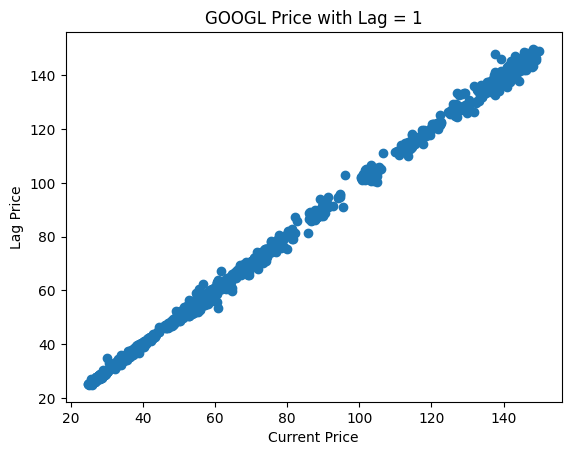

In [ ]:
## Creating a lag plot with a lag of 1 day
pd.plotting.lag_plot(train_googl, lag=1, ax=None)
plt.title('GOOGL Price with Lag = 1')
plt.xlabel("Current Price")
plt.ylabel(f"Lag Price")
plt.show()

# strong indication of autocorrelation

In [ ]:
## Check if my data is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_googl)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

# not stationary because p-value > 0.05 so we need differencing

ADF Statistic: 1.1668896626292382
p-value: 0.9957489452814546


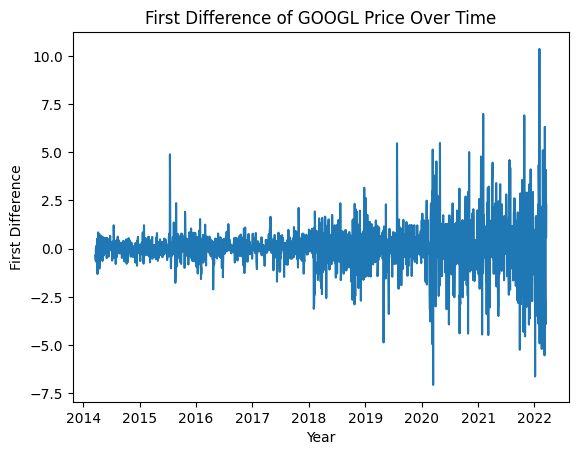

In [ ]:
## Checking if first order detrending will make data stationary
first_difference = train_googl['Adj Close'].diff().dropna()

# Plotting
plt.plot(first_difference.index, first_difference)
plt.xlabel('Year')
plt.ylabel('First Difference')
plt.title('First Difference of GOOGL Price Over Time')
plt.show()

# this is sufficiently stationary

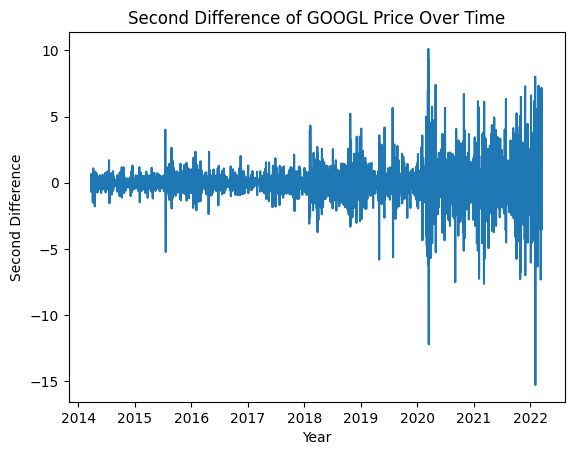

In [ ]:
## Trying second order
second_difference = train_googl['Adj Close'].diff().diff().dropna()

# Plotting
plt.plot(second_difference.index, second_difference)
plt.xlabel('Year')
plt.ylabel('Second Difference')
plt.title('Second Difference of GOOGL Price Over Time')
plt.show()

# there isn't a huge change but we can still try it

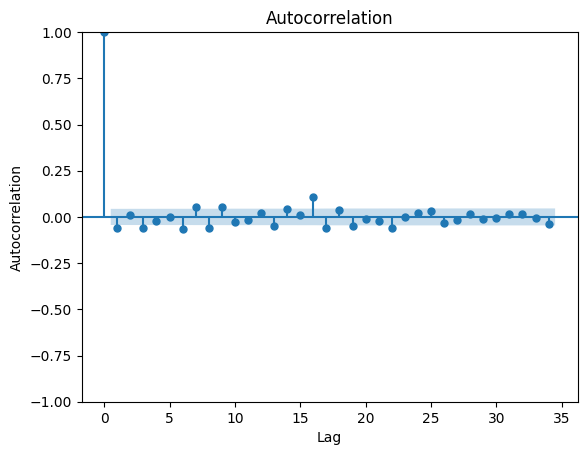

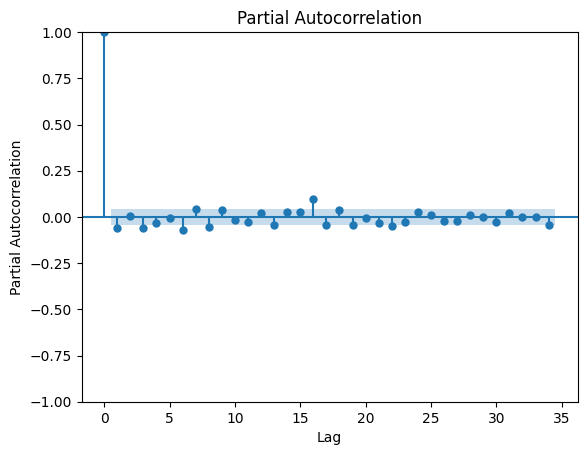

In [ ]:
## Autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(first_difference)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# acf plot shows 1 lag cross significance line - possible q term

# Plot PACF
plot_pacf(first_difference)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')

plt.show()

# pacf plot shows 1 lag crossing the significance limit - possible p term
# the plots look suspiciously similar so i can't rely on them
# could be suboptimal differencing degree

After concluding the existence of autocorrelation and determining the necessity for differencing to at least the first degree, I trained an ARIMA model. To find suitable parameters, I used GridSearch to iterate over a combination of p, q and d parameters. As the visualisations failed to provide definitive starting p and q parameters, I integrated existing research to determine them. I chose MAE as the loss function based on research as well (Loukas, 2020).

In [ ]:
## Utilise GridSearch find best ARIMA parameters
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from sklearn.metrics import mean_absolute_error

origin, today = "2014-03-20", "2022-03-18"
googl_series = train_googl[origin:today]['Adj Close'].asfreq("D")

# Set possible p,d,q values
p_values = [1, 5]
d_values = [1, 3]
q_values = [0, 1]

best_mae = np.inf
best_params = None

# Perform grid search
for p, d, q in product(p_values, d_values, q_values):
    try:
        arima = ARIMA(googl_series, order=(p, d, q))
        model_arima = arima.fit()

        forecast = model_arima.forecast(steps=len(val_googl))

        mae = mean_absolute_error(val_googl['Adj Close'], forecast)
        if mae < best_mae:
            best_mae = mae
            best_params = (p, d, q)
    except:
        continue

print("Best MAE:", best_mae)
print("Best Parameters (p, d, q):", best_params)

Best MAE: 29.407967905355143
Best Parameters (p, d, q): (5, 1, 1)


Making predictions on the best ARIMA model (5,1,1) on the validation dataset yielded the following results.

In [16]:
## Train best ARIMA model
arima = ARIMA(googl_series,
              order=(5,1,1))
model_arima = arima.fit()

## Create forecasts
forecast = model_arima.forecast(len(val_googl))

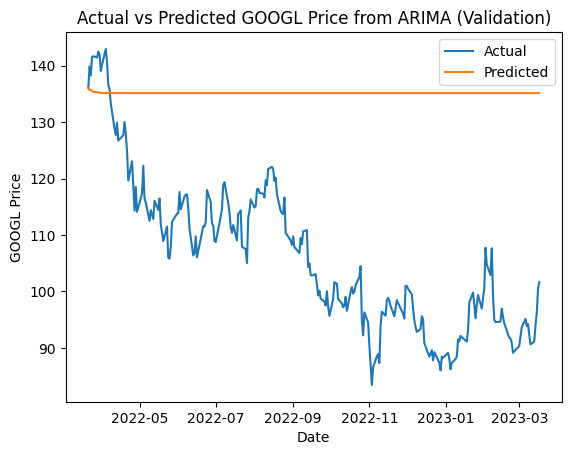

In [ ]:
## Plot predictions on validation
plt.plot(val_googl.index, val_googl['Adj Close'], label='Actual')
plt.plot(val_googl.index, forecast, label='Predicted')
plt.xlabel('Date')
plt.ylabel('GOOGL Price')
plt.title('Actual vs Predicted GOOGL Price from ARIMA (Validation)')
plt.legend()

plt.show()

The ARIMA model is unable to come up with a meaningful trend and defaults to a straight-line prediction. The MAE is also fairly high at ~29.41. While it’s possible that the parameters tried were wholly unsuitable, as I’ve already implemented hyperparameter tuning, I decided it may be better to try a different method of re-training the model everyday, effectively creating a rolling forecast which can enable more adaptive predictions (Brownlee, 2017). I limited the validation data to three months to speed up training.

In [ ]:
## Retraining ARIMA every day
from statsmodels.tsa.arima.model import ARIMA

all_googl = pd.concat([train_googl, val_googl])

origin, start_date, end_date = "2014-03-20", "2022-03-21", "2022-05-21"
time_period = pd.bdate_range(start_date, end_date)

val_arima = all_googl.loc[start_date:end_date]
train_arima = all_googl.loc[origin:end_date]

google_series = train_arima["Adj Close"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    arima_model = ARIMA(google_series[origin:today], order=(5,1,1))
    arima_model = arima_model.fit()
    y_pred = arima_model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)

In [ ]:
## Calculating MAE
y_preds = y_preds.drop(index= '2022-04-15')

mae = mean_absolute_error(val_arima['Adj Close'], y_preds)
print("Val MAE:", mae)

Val MAE: 2.4385537762209464


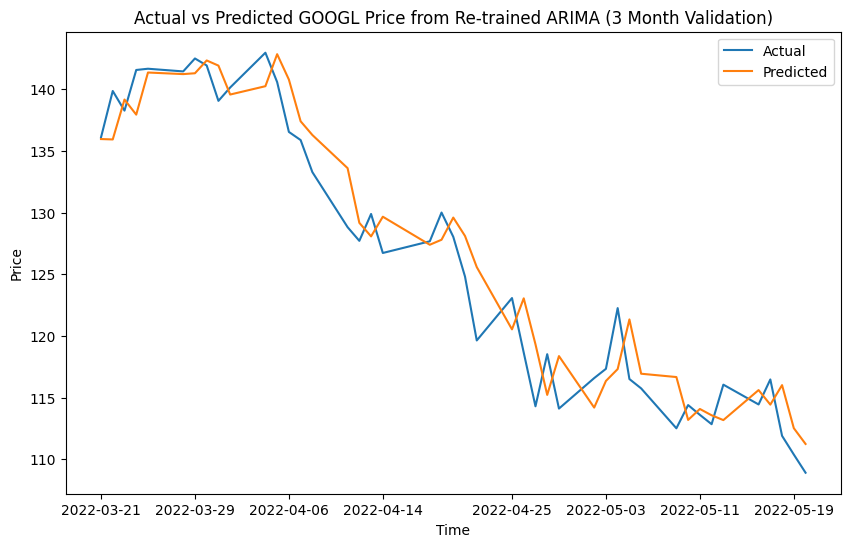

In [ ]:
## Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(val_arima.index, val_arima['Adj Close'], label='Actual')
plt.plot(val_arima.index, y_preds, label='Predicted')
plt.xticks(val_arima.index[::6])
plt.title('Actual vs Predicted GOOGL Price from Re-trained ARIMA (3 Month Validation)')
plt.xlabel('Time')
plt.ylabel('Price')

plt.legend()
plt.show()

This drastically reduced MAE to ~2.44 and provided predictions that varied over time. While the error is low, given that this model can only predict tomorrow's price and needs to be retrained daily, it isn’t the most practical or impressive model. Investors usually want forecasts over a greater time period as stock prices are unlikely to vary much day-to-day. Nevertheless, with a baseline model in place, I then developed more sophisticated non-time series specific models.

<a id="Feature-Engineering"></a>
## 4. Feature Engineering

To prepare the time-series data for modelling, I reframed it using lag features and window statistics. Additionally, to add more dimensionality to the data, I incorporated common technical analysis indicators to measure the characteristics of stock price changes (Potter, 2023). Using the package ‘ta’ (Padial, 2018), I created the following nine features:

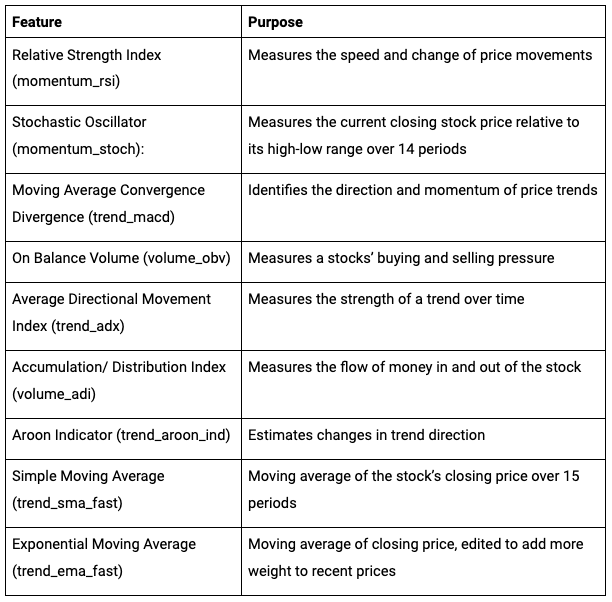

In [ ]:
# Split time series again as we need all columns
test_googl = df_company_returns[df_company_returns['Date'] >= '2023-03-20']
val_googl = df_company_returns[(df_company_returns['Date'] < '2023-03-20') 
                               & (df_company_returns['Date'] >= '2022-03-20')]
train_googl = df_company_returns[df_company_returns ['Date'] < '2022-03-20']

In [ ]:
## Creating technical features
from ta import add_all_ta_features
from ta.utils import dropna

technical_df = add_all_ta_features(
    train_googl.copy(), open='Open', high='High', low='Low', close='Close', 
    volume = 'Volume', fillna=True
)

In [ ]:
## Selecting only the 9 important features and time and adj close
ta_columns = ['Date', 'Adj Close', 'momentum_rsi', 'momentum_stoch', 
              'trend_macd', 'volume_obv', 'trend_adx', 'volume_adi', 
              'trend_aroon_ind', 'trend_sma_fast', 'trend_ema_fast']
technical_df = technical_df[ta_columns]
technical_df.head()

,Date,Adj Close,momentum_rsi,momentum_stoch,trend_macd,volume_obv,trend_adx,volume_adi,trend_aroon_ind,trend_sma_fast,trend_ema_fast
0,2014-03-20,29.958960,100.000000,12.631833,0.000000,67320612,0.0,-5.031296e+07,0.0,29.958960,29.958960
1,2014-03-21,29.605606,0.000000,2.170749,-0.028188,-60891048,0.0,-1.729583e+08,0.0,29.782283,29.904598
2,2014-03-24,28.977226,0.000000,18.812759,-0.100078,-182253564,0.0,-2.196651e+08,-4.0,29.513931,29.761925
3,2014-03-25,28.996998,2.177664,20.053477,-0.153685,-85941972,0.0,-2.171347e+08,-4.0,29.384698,29.644244
4,2014-03-26,28.327578,1.213856,0.601523,-0.247334,-189038772,0.0,-3.178131e+08,-12.0,29.173274,29.441680


In [ ]:
## Repeat for validation and test

# Define function
def technical_features(data):
  data = add_all_ta_features(data, open='Open', high='High', low='Low', 
                             close='Close', volume = 'Volume', fillna=True)
  ta_columns = ['Date', 'Adj Close', 'momentum_rsi', 'momentum_stoch', 
                'trend_macd', 'volume_obv', 'trend_adx', 'volume_adi', 
                'trend_aroon_ind', 'trend_sma_fast', 'trend_ema_fast']
  processed_data = data[ta_columns]
  return processed_data

# validation data
technical_val = technical_features(val_googl.copy())

# test data
technical_test = technical_features(test_googl.copy())

Next, I calculated the expanding window mean. I didn’t calculate sliding window means since I already have simple moving averages and exponential moving averages.

In [ ]:
## Creating expanding window features
expanding_window = train_googl['Adj Close'].expanding()

# extracting just the mean
expanding_mean = expanding_window.mean()

# combining datasets
time_train = pd.concat([technical_df, expanding_mean.rename('Expanding Mean')], axis=1)
time_train.head()

,Date,Adj Close,momentum_rsi,momentum_stoch,trend_macd,volume_obv,trend_adx,volume_adi,trend_aroon_ind,trend_sma_fast,trend_ema_fast,Expanding Mean
0,2014-03-20,29.958960,100.000000,12.631833,0.000000,67320612,0.0,-5.031296e+07,0.0,29.958960,29.958960,29.958960
1,2014-03-21,29.605606,0.000000,2.170749,-0.028188,-60891048,0.0,-1.729583e+08,0.0,29.782283,29.904598,29.782283
2,2014-03-24,28.977226,0.000000,18.812759,-0.100078,-182253564,0.0,-2.196651e+08,-4.0,29.513931,29.761925,29.513931
3,2014-03-25,28.996998,2.177664,20.053477,-0.153685,-85941972,0.0,-2.171347e+08,-4.0,29.384698,29.644244,29.384698
4,2014-03-26,28.327578,1.213856,0.601523,-0.247334,-189038772,0.0,-3.178131e+08,-12.0,29.173274,29.441680,29.173274


In [ ]:
# Repeat for validation and test
expanding_mean_val = val_googl['Adj Close'].expanding().mean()
expanding_mean_test= test_googl['Adj Close'].expanding().mean()

time_val = pd.concat([technical_val, expanding_mean_val.rename('Expanding Mean')], axis = 1)
time_test = pd.concat([technical_test, expanding_mean_test.rename('Expanding Mean')], axis = 1)

When it comes to creating the sliding windows themselves, I used a random forest to determine the optimal window size. I trained a random forest with 50 lag points (an arbitrarily large size), then examined the importance of each lag variable through a feature importance graph.

In [ ]:
## Create sliding windows

# Define lag features function
def create_lag(data, target_var, sequence_length):

  data = data.drop(columns = ['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
  data.set_index('Date', inplace= True)

  lagged_features = pd.concat([data.shift(i) for i in range(sequence_length, 0, -1)], axis=1)
  lagged_features.columns = [f'Lag_{i}_{col}' for i in range(sequence_length, 0, -1) for col in data.columns]
  target_variable = data[target_var]
  lag_df = pd.concat([lagged_features, target_variable], axis=1).dropna()
  return lag_df

# Creating a test lag window of 50
train_lag = create_lag(train_googl, 'Adj Close', 50)
train_lag.head()

,Lag_50_Adj Close,Lag_49_Adj Close,Lag_48_Adj Close,Lag_47_Adj Close,Lag_46_Adj Close,Lag_45_Adj Close,Lag_44_Adj Close,Lag_43_Adj Close,Lag_42_Adj Close,Lag_41_Adj Close,...,Lag_9_Adj Close,Lag_8_Adj Close,Lag_7_Adj Close,Lag_6_Adj Close,Lag_5_Adj Close,Lag_4_Adj Close,Lag_3_Adj Close,Lag_2_Adj Close,Lag_1_Adj Close,Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-02,29.958960,29.605606,28.977226,28.996998,28.327578,27.884886,28.031782,27.890640,28.400652,28.405907,...,26.941500,27.019501,27.485001,27.772499,28.190001,28.743500,28.522499,28.528000,28.582500,28.216999
2014-06-03,29.605606,28.977226,28.996998,28.327578,27.884886,28.031782,27.890640,28.400652,28.405907,28.575001,...,27.019501,27.485001,27.772499,28.190001,28.743500,28.522499,28.528000,28.582500,28.216999,27.725500
2014-06-04,28.977226,28.996998,28.327578,27.884886,28.031782,27.890640,28.400652,28.405907,28.575001,27.262501,...,27.485001,27.772499,28.190001,28.743500,28.522499,28.528000,28.582500,28.216999,27.725500,27.688000
2014-06-05,28.996998,28.327578,27.884886,28.031782,27.890640,28.400652,28.405907,28.575001,27.262501,27.031500,...,27.772499,28.190001,28.743500,28.522499,28.528000,28.582500,28.216999,27.725500,27.688000,28.246500
2014-06-06,28.327578,27.884886,28.031782,27.890640,28.400652,28.405907,28.575001,27.262501,27.031500,27.875500,...,28.190001,28.743500,28.522499,28.528000,28.582500,28.216999,27.725500,27.688000,28.246500,28.301500


In [ ]:
## Train Random Forest to get feature importance
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100)
X_train = train_lag.drop(columns = ['Adj Close'])

# Train the model
rf_regressor.fit(X_train, train_lag['Adj Close'])

# Feature importance
feature_importances = rf_regressor.feature_importances_

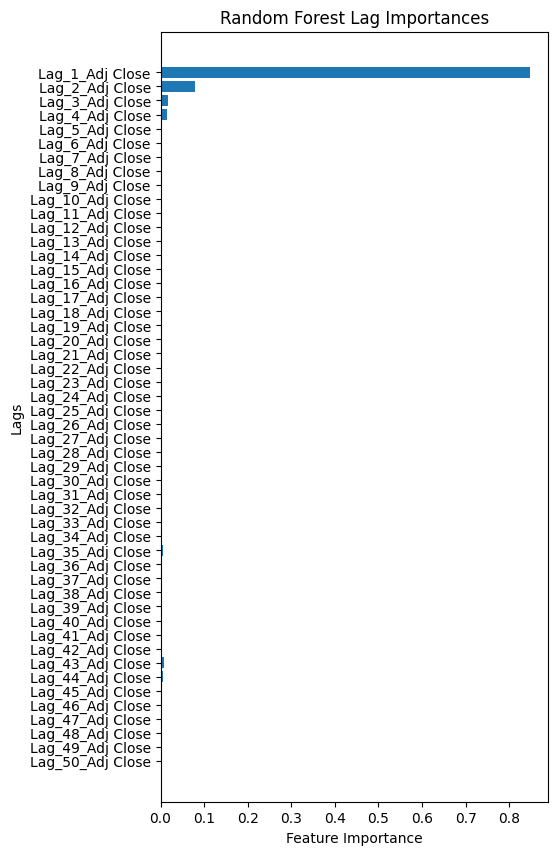

In [ ]:
## Plotting feature importance
plt.figure(figsize = (5,10))
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Lags')
plt.title('Random Forest Lag Importances')
plt.show()

Although only the first four lag variables contributed to predictions, I settled on a window size of 15 (3 trading weeks) to widen the context provided to the model and align the sliding window with moving average statistics.

In [ ]:
## Recreating sliding window feature using lag = 15
train_lag = create_lag(train_googl,'Adj Close', 15)
val_lag = create_lag(val_googl,'Adj Close', 15)
test_lag = create_lag(test_googl,'Adj Close', 15)

# Deleting shifted adjusted close variables otherwise it'll repeat
train_lag.drop(columns=['Adj Close'], inplace=True)
val_lag.drop(columns=['Adj Close'], inplace=True)
test_lag.drop(columns=['Adj Close'], inplace=True)

In [ ]:
## Joining datasets together

# Getting back the date column
train_lag.reset_index(inplace=True)
val_lag.reset_index(inplace= True)
test_lag.reset_index(inplace= True)

# Merge on time
train_googl_rf = pd.merge(time_train, train_lag, on='Date')
val_googl_rf = pd.merge(time_val, val_lag, on='Date')
test_googl_rf = pd.merge(time_test, test_lag, on='Date')

<a id="Random-Forest"></a>
## 5. Ensemble Model: Random Forest

With these newly created features, I trained a random forest regressor, using 100 trees by convention.


In [ ]:
# Define X var
X_train = train_googl_rf.drop(columns = ['Adj Close', 'Date'])
X_val = val_googl_rf.drop(columns = ['Adj Close', 'Date'])
X_test = test_googl_rf.drop(columns = ['Adj Close', 'Date'])

In [ ]:
## Training random forest

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100)

# Train the model
rf_regressor.fit(X_train, train_googl_rf['Adj Close'])

RandomForestRegressor()

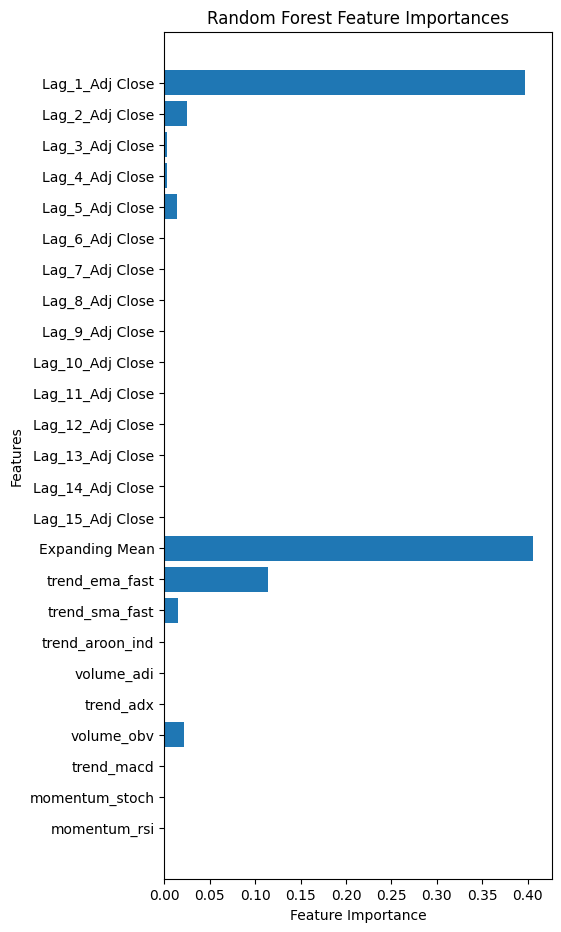

In [ ]:
## Feature importance plot
feature_importances = rf_regressor.feature_importances_

plt.figure(figsize = (5,11))
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importances')
plt.show()

The feature importance graph shows only a few meaningful variables. Unlike the previous plot, the first 5, not 4, lag values contributed to predictions. Out of the technical features, only the exponential moving average, simple moving average and on balance volume were important. Surprisingly, the expanding mean had the highest importance, along with, unsurprisingly, the closest lag value.

In [ ]:
## Make predictions on the validation set
y_pred = rf_regressor.predict(X_val)

## Evaluate model performance
mae = mean_absolute_error(val_googl_rf['Adj Close'], y_pred)
print("Val MAE:", mae)

Val MAE: 5.745121151234039


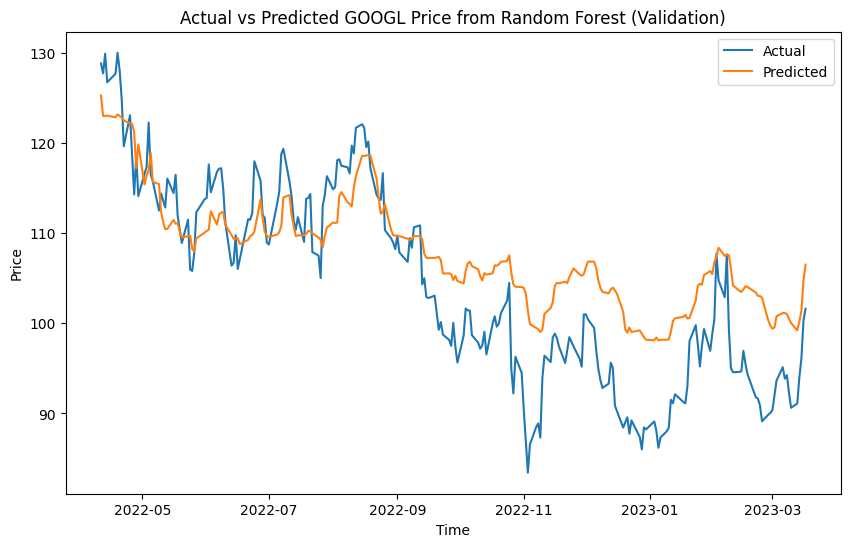

In [ ]:
## Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(val_googl_rf['Date'], val_googl_rf['Adj Close'], label='Actual')
plt.plot(val_googl_rf['Date'], y_pred, label='Predicted')
plt.title('Actual vs Predicted GOOGL Price from Random Forest (Validation)')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

Observing the performance of the random forest, the validation MAE sits at ~5.75, higher than our daily ARIMA model. The plots confirm that while the random forest is able to capture the direction of price changes, correctly identifying an overall decline in price and most peaks and troughs in the right place, it struggles with gauging the magnitude of the changes. It underestimates prices before September 2022 and overestimates prices after September 2022. However, it should be noted that the random forest can forecast over a longer time frame than the ARIMA and MAE was calculated using 12 months of data instead of just 3 months.

<a id="Neural-Network"></a>
## 6. Neural Network: RNN

Finally, I built the neural network. A recurrent neural network chosen due to its compatibility with time series data. Unlike conventional feedforward neural networks, RNN’s ‘memory’ capabilities allow it to consider sequential dependencies.

Prior to training the model, I performed feature selection, keeping only the technical analysis features deemed important by the random forest in addition to the expanding mean and the entire sliding window.


In [ ]:
# Making a copy of the data before processing
train_googl_nn = train_googl_rf.copy()
val_googl_nn = val_googl_rf.copy()
test_googl_nn = test_googl_rf.copy()

# Drop the date column, make it index
train_googl_nn.set_index('Date', inplace=True)
val_googl_nn.set_index('Date', inplace=True)
test_googl_nn.set_index('Date', inplace=True)

In [ ]:
## Feature selection based on importances
train_googl_nn.drop(columns = ['momentum_rsi', 'momentum_stoch', 'trend_macd', 'trend_adx', 
                               'volume_adi', 'trend_aroon_ind'], inplace= True)
val_googl_nn.drop(columns = ['momentum_rsi', 'momentum_stoch', 'trend_macd', 'trend_adx', 
                             'volume_adi', 'trend_aroon_ind'], inplace= True)
test_googl_nn.drop(columns = ['momentum_rsi', 'momentum_stoch', 'trend_macd', 'trend_adx', 
                              'volume_adi', 'trend_aroon_ind'], inplace=True)

In [ ]:
## Normalising data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit scaler
scaler.fit(train_googl_nn)

# Transform the data using the fitted scaler
train_googl_nns = train_googl_nn.copy()
train_googl_nns.loc[:, train_googl_nn.columns] = scaler.transform(train_googl_nn)

val_googl_nns = val_googl_nn.copy()
val_googl_nns.loc[:, val_googl_nn.columns] = scaler.transform(val_googl_nn)

test_googl_nns = test_googl_nn.copy()
test_googl_nns.loc[:, test_googl_nn.columns] = scaler.transform(test_googl_nn)

In [ ]:
## Define X
X_train = train_googl_nns.drop(columns = ['Adj Close'])
X_val = val_googl_nns.drop(columns = ['Adj Close'])
X_test = test_googl_nns.drop(columns = ['Adj Close'])

In [ ]:
# Convert to Numpy array
X_train, y_train = np.array(X_train), np.array(train_googl_nns['Adj Close'])

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train:",X_train.shape,"y_train :",y_train.shape)

X_train: (2000, 19, 1) y_train : (2000, 1)


In [ ]:
# Repeat for val
X_val, y_val = np.array(X_val), np.array(val_googl_nns['Adj Close'])

#Reshaping
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val = np.reshape(y_val, (y_val.shape[0],1))
print("X_val:",X_val.shape,"y_val :",y_val.shape)

# Repeat for test
X_test, y_test = np.array(X_test), np.array(test_googl_nns['Adj Close'])

# Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test:",X_test.shape,"y_test:",y_test.shape)

X_val: (235, 19, 1) y_val : (235, 1)
X_test: (238, 19, 1) y_test: (238, 1)


After normalising the data using a standard scaler and performing basic preprocessing, I trained a single-layer SimpleRNN using parameters and an optimiser recommended by a similar research study (Kamalov, Smail and Gurrib, 2020).

In [ ]:
## Train simple RNN
rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(units=6, input_shape = (19,1), 
                              return_sequences = False),
    tf.keras.layers.Dense(1)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mae', metrics = ['mse'])

# Fit the model to your training dataset
history = rnn_model.fit(X_train, y_train, epochs=50, batch_size = 32, 
                        validation_data= (X_val, y_val))

Epoch 1/50
63/63 [==============================] - 4s 33ms/step - loss: 0.3998 - mse: 0.4291 - val_loss: 0.4795 - val_mse: 0.3041
Epoch 2/50
63/63 [==============================] - 1s 22ms/step - loss: 0.2093 - mse: 0.1936 - val_loss: 0.2340 - val_mse: 0.0962
Epoch 3/50
63/63 [==============================] - 1s 24ms/step - loss: 0.1440 - mse: 0.1097 - val_loss: 0.1660 - val_mse: 0.0410
Epoch 4/50
63/63 [==============================] - 1s 19ms/step - loss: 0.1048 - mse: 0.0601 - val_loss: 0.1622 - val_mse: 0.0366
Epoch 5/50
63/63 [==============================] - 1s 22ms/step - loss: 0.0797 - mse: 0.0310 - val_loss: 0.1585 - val_mse: 0.0352
Epoch 6/50
63/63 [==============================] - 1s 20ms/step - loss: 0.0631 - mse: 0.0169 - val_loss: 0.1664 - val_mse: 0.0377
Epoch 7/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0535 - mse: 0.0102 - val_loss: 0.1386 - val_mse: 0.0275
Epoch 8/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0467 - m

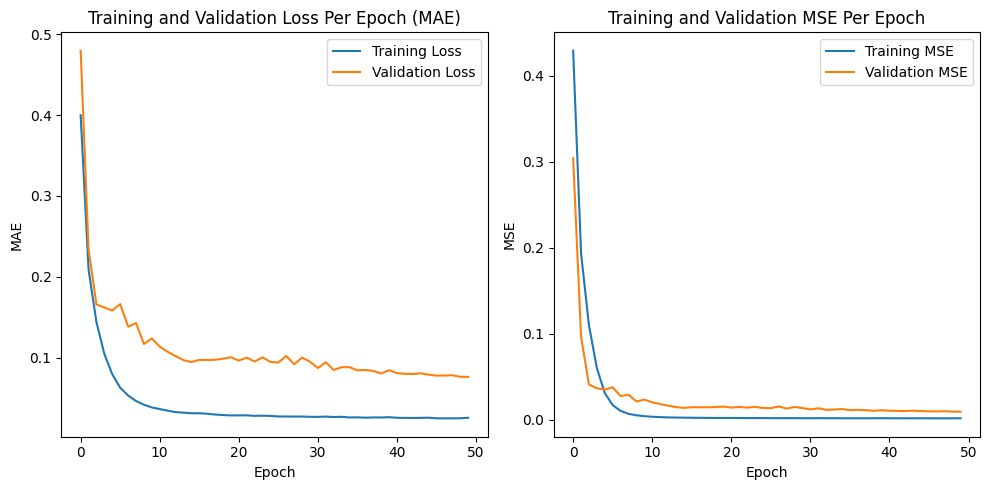

In [ ]:
## Error Plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plotting the training and validation MSE (loss)
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss Per Epoch (MAE)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

# Plotting training and validation MSE
# additional metric for more insight but you can ignore
axes[1].plot(history.history['mse'], label='Training MSE')
axes[1].plot(history.history['val_mse'], label='Validation MSE')
axes[1].set_title('Training and Validation MSE Per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE')
axes[1].legend()

plt.tight_layout()
plt.show()

Looking at the MAE error plot, training loss drops drastically then plateaus after only several epochs of training. Validation loss follows a similar trend but fluctuates slightly and instead of stagnating, declines at a very slight rate, steadying over the final few epochs where improvements are marginal. The model seems to be fitted properly as convergence is reached. But the continued gap between the training loss signals issues with the model’s ability to generalise and may suggest the wrong parameters were used. Given the smoothness and trend of the curves, I didn’t think adjustments to the learning rate were necessary.

In [ ]:
## Descale data
means = scaler.mean_[0]
stds = scaler.scale_[0]

## Generate predictions
predictions_val = rnn_model.predict(X_val)
descaled_preds_val = predictions_val * stds + means

## Calculate loss metric
val_mae = mean_absolute_error(val_googl_nn['Adj Close'], descaled_preds_val)
print('Val MAE:', val_mae)

8/8 [==============================] - 0s 5ms/step
Val MAE: 2.464574023341921


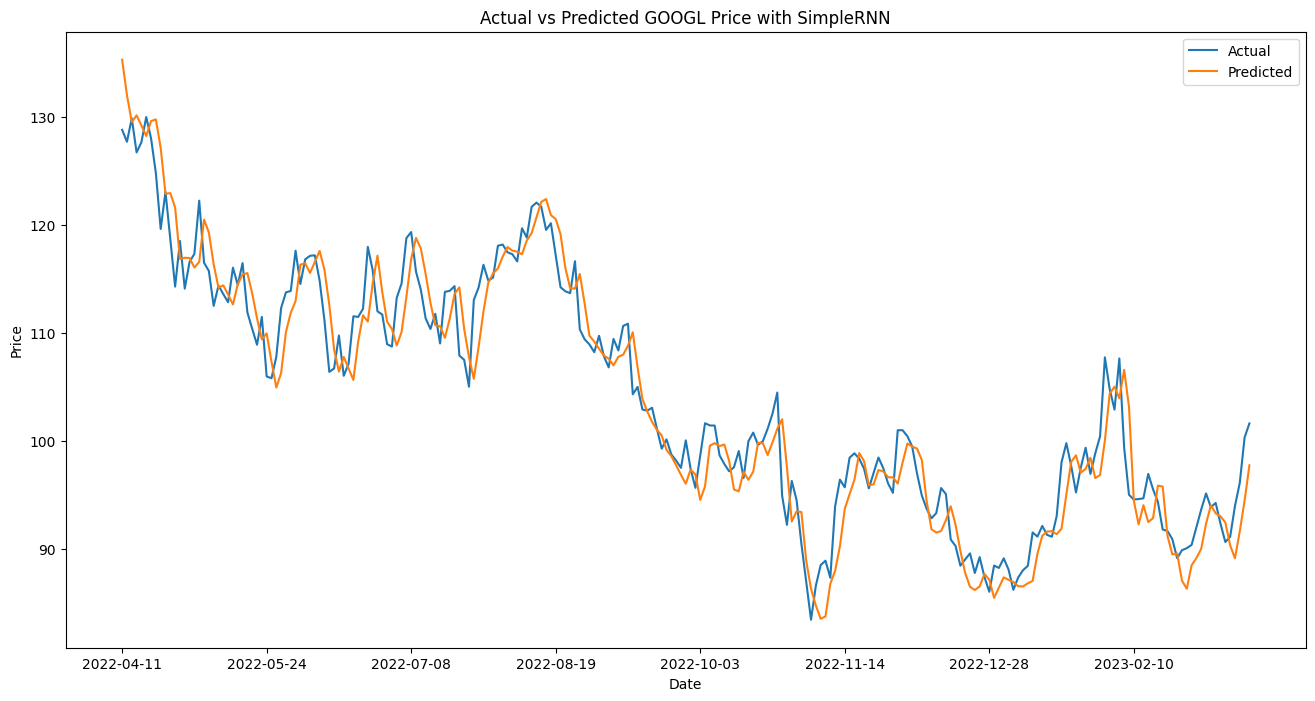

In [ ]:
## Plot actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(val_googl_nn.index, val_googl_nn['Adj Close'], label='Actual')
plt.plot(val_googl_nn.index, descaled_preds_val, label='Predicted')
plt.title('Actual vs Predicted GOOGL Price with SimpleRNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(val_googl_nn.index[::30])
plt.legend()
plt.show()

The simple RNN seems to generate better predictions than the random forest. Validation MAE sits at ~2.46, lower than the random forest but slightly higher than the daily ARIMA. To further decrease loss, I used hyperparameter tuning to find the best RNN.

### Fine-tuned RNN

To deal with possible vanishing gradients and consider long-term dependencies, I also tested LSTM layers. As existing research indicates fewer layers to be better, I limited the depth of the neural network to at most two layers. The number of nodes and drop-out rates were also set based on research. Since some of the models iterated through will be simpler than the first RNN model, I’ve implemented early stopping to prevent potential overfitting.

In [ ]:
# import all packages for NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from sklearn.model_selection import ParameterGrid
from keras.callbacks import EarlyStopping

In [ ]:
## Deep RNN with hyperparameter tuning

# define parameter grid
param_grid = {
    'add_layer': [0, 1],
    'layer_type': [SimpleRNN, LSTM], # either adds another RNN or LSTM layer
    'nodes': [4, 5, 6],
    'dropout_rate': [0, 0.2]
}

# define rnn model function
def create_rnn_model(hparams, X_train, y_train, X_val, y_val):
  model = Sequential()

  # Add additional RNN or LSTM layer
  for _ in range(hparams['add_layer']):
    model.add(hparams['layer_type'](hparams['nodes'], input_shape = (19,1), 
                                    return_sequences= True))
    model.add(Dropout(hparams['dropout_rate']))

  # Last layer needs to return_sequences = False
  model.add(hparams['layer_type'](hparams['nodes'], return_sequences = False))
  model.add(Dropout(hparams['dropout_rate']))

  # Final dense layer
  model.add(Dense(1))

  # Implementing early stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, 
                                 restore_best_weights=True)

  # Compile the model
  model.compile(optimizer='adam', loss='mae', metrics = ['mse'])

  # Fit model
  history2 = model.fit(X_train, y_train, epochs= 50, batch_size=32, 
                       validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])

  return history2.history['val_loss'][-1]

In [ ]:
## Execute Grid Search
results = []

# Iterate over parameters
for params in ParameterGrid(param_grid):
  val_loss = create_rnn_model(params, X_train, y_train, X_val, y_val)
  results.append({'params': params, 'loss': val_loss})

# Save to dataframe
results_df = pd.DataFrame(results)
best_params = results_df.sort_values(by='loss', ascending=True).iloc[0]

print("Best Parameters: ", best_params['params'])
print("Best Loss: ", best_params['loss']) # this is the scaled loss

Best Parameters:  {'add_layer': 1, 'dropout_rate': 0, 'layer_type': <class 'keras.src.layers.rnn.simple_rnn.SimpleRNN'>, 'nodes': 4}
Best Loss:  0.06744633615016937


In [ ]:
## Let's see all of them
results_df

,params,loss
0,"{'add_layer': 0, 'dropout_rate': 0, 'layer_typ...",0.068284
1,"{'add_layer': 0, 'dropout_rate': 0, 'layer_typ...",0.567321
2,"{'add_layer': 0, 'dropout_rate': 0, 'layer_typ...",0.381656
3,"{'add_layer': 0, 'dropout_rate': 0, 'layer_typ...",0.087643
4,"{'add_layer': 0, 'dropout_rate': 0, 'layer_typ...",0.075162
5,"{'add_layer': 0, 'dropout_rate': 0, 'layer_typ...",0.097914
6,"{'add_layer': 0, 'dropout_rate': 0.2, 'layer_t...",0.200988
7,"{'add_layer': 0, 'dropout_rate': 0.2, 'layer_t...",0.101855
8,"{'add_layer': 0, 'dropout_rate': 0.2, 'layer_t...",0.071645
9,"{'add_layer': 0, 'dropout_rate': 0.2, 'layer_t...",0.189257


The best RNN turned out to be the simplest: 1 SimpleRNN layer, no drop-out with 4 nodes. I retrained the RNN with these parameters.

In [ ]:
## Retrain best model
best_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(units= 4, input_shape = (19,1), return_sequences = False),
    tf.keras.layers.Dense(1)
])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model
best_model.compile(optimizer='adam', loss='mae', metrics = ['mse'])

# Fit the model
history3 = best_model.fit(X_train, y_train, epochs=50, batch_size = 32, 
                          validation_data= (X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
63/63 [==============================] - 4s 27ms/step - loss: 1.8361 - mse: 4.4148 - val_loss: 2.7626 - val_mse: 7.7896
Epoch 2/50
63/63 [==============================] - 2s 26ms/step - loss: 1.1723 - mse: 2.5006 - val_loss: 2.3201 - val_mse: 5.5089
Epoch 3/50
63/63 [==============================] - 2s 27ms/step - loss: 0.7654 - mse: 1.3993 - val_loss: 1.0308 - val_mse: 1.3086
Epoch 4/50
63/63 [==============================] - 2s 25ms/step - loss: 0.4469 - mse: 0.5896 - val_loss: 0.5266 - val_mse: 0.3931
Epoch 5/50
63/63 [==============================] - 2s 25ms/step - loss: 0.3441 - mse: 0.3219 - val_loss: 0.3904 - val_mse: 0.2321
Epoch 6/50
63/63 [==============================] - 2s 24ms/step - loss: 0.2746 - mse: 0.2181 - val_loss: 0.2879 - val_mse: 0.1394
Epoch 7/50
63/63 [==============================] - 1s 16ms/step - loss: 0.2105 - mse: 0.1527 - val_loss: 0.2049 - val_mse: 0.0744
Epoch 8/50
63/63 [==============================] - 1s 14ms/step - loss: 0.1525 - m

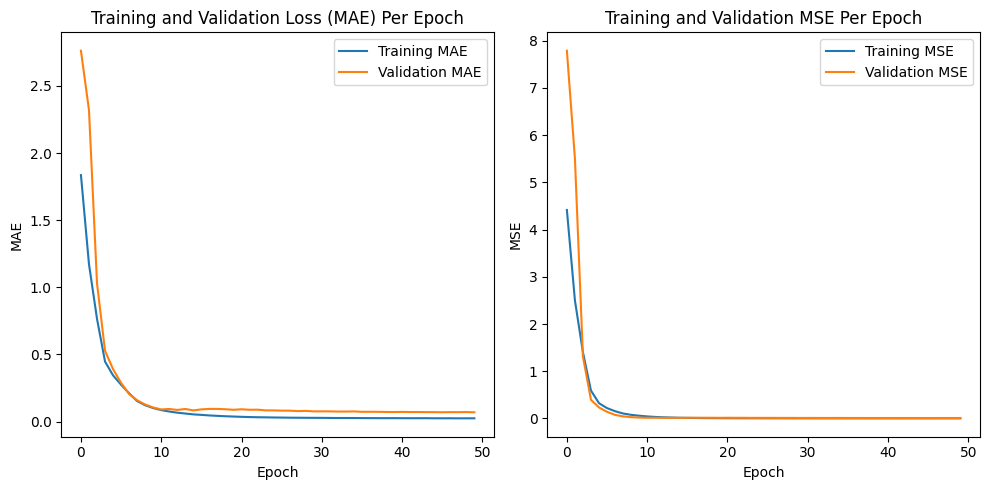

In [ ]:
## Error Plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plotting the training and validation loss
axes[0].plot(history3.history['loss'], label='Training MAE')
axes[0].plot(history3.history['val_loss'], label='Validation MAE')
axes[0].set_title('Training and Validation Loss (MAE) Per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

# Plotting training and validation MSE - additional metric can ignore
axes[1].plot(history3.history['mse'], label='Training MSE')
axes[1].plot(history3.history['val_mse'], label='Validation MSE')
axes[1].set_title('Training and Validation MSE Per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE')
axes[1].legend()

plt.tight_layout()
plt.show()

Like the previous error plot, both the training and validation loss decrease then plateau. Here, the training and validation MAEs are much closer, with the validation MAE even exceeding the training MAE after a few epochs, emphasising the model’s ability to generalise. This could be due to its architecture being simpler with 4 nodes instead of 6. The model also reaches convergence faster, likely also due to its simplicity.

### Predictions with RNN

In [ ]:
## Generate predictions on test and val
predictions_test = best_model.predict(X_test)
predictions_val = best_model.predict(X_val)

## Descale data
means = scaler.mean_[0]
stds = scaler.scale_[0]

## Find descaled predictions
descaled_preds_test = predictions_test * stds + means
descaled_preds_val = predictions_val * stds + means

8/8 [==============================] - 0s 3ms/step


In [ ]:
## Evaluate descaled MAE for val and test
val_mae = mean_absolute_error(val_googl_nn['Adj Close'], descaled_preds_val)
test_mae = mean_absolute_error(test_googl_nn['Adj Close'], descaled_preds_test)
print('Val MAE:', val_mae)
print('Test MAE:', test_mae)

Val MAE: 2.2269111828582115
Test MAE: 1.8441758134991304


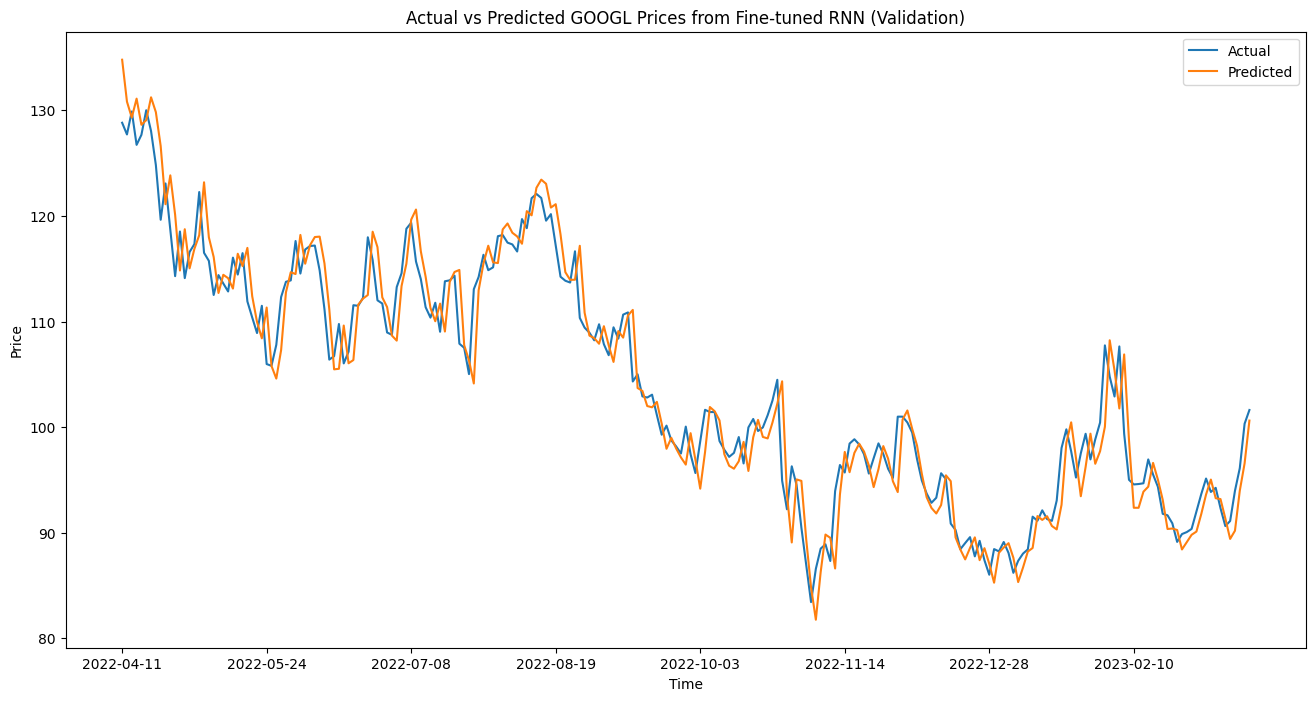

In [ ]:
## Plot validation
plt.figure(figsize=(16, 8))

plt.plot(val_googl_nn.index, val_googl_nn['Adj Close'], label = 'Actual')
plt.plot(val_googl_nn.index, descaled_preds_val, label='Predicted')
plt.xticks(val_googl_nn.index[::30])

plt.ylabel('Price')
plt.xlabel('Time')
plt.title('Actual vs Predicted GOOGL Prices from Fine-tuned RNN (Validation)')
plt.legend()
plt.show()

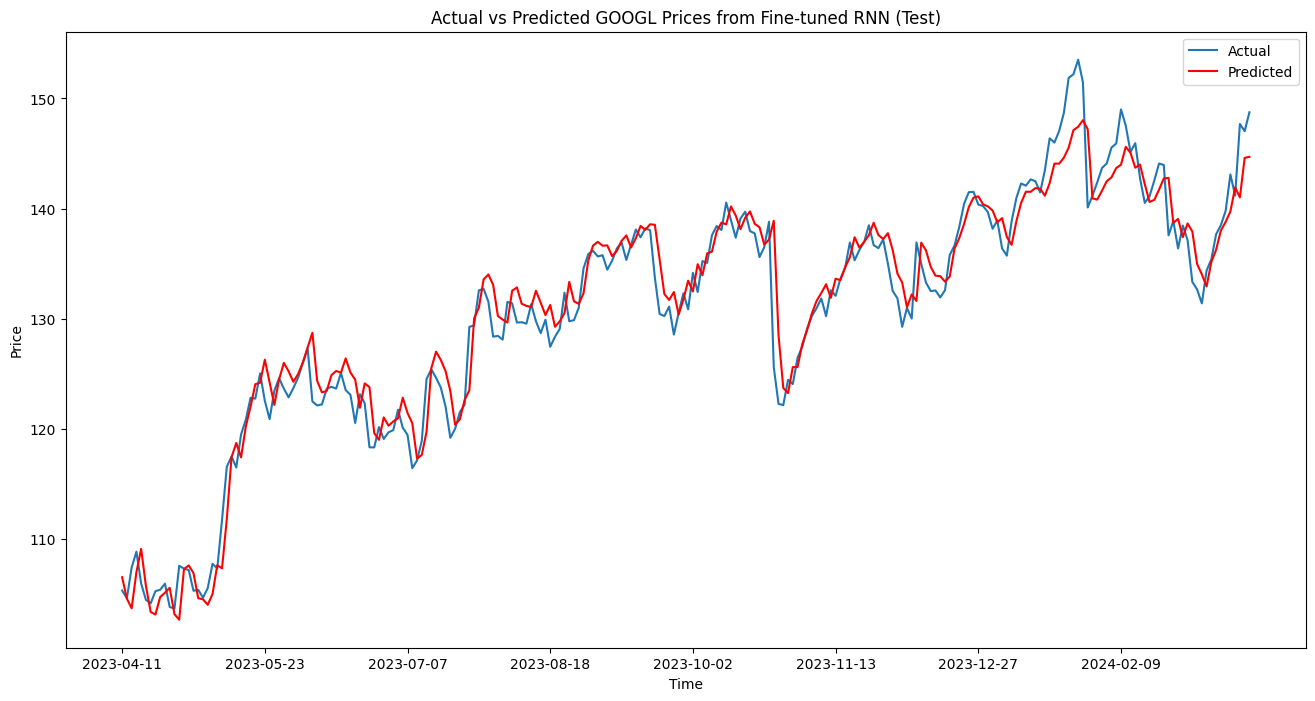

In [ ]:
## Plot test
plt.figure(figsize=(16, 8))
plt.plot(test_googl_nn.index, test_googl_nn['Adj Close'], label= 'Actual')
plt.plot(test_googl_nn.index, descaled_preds_test, color= 'red', label='Predicted')
plt.xticks(test_googl_nn.index[::30])

plt.ylabel('Price')
plt.xlabel('Time')
plt.title('Actual vs Predicted GOOGL Prices from Fine-tuned RNN (Test)')
plt.legend()
plt.show()

The validation MAE is the lowest yet at ~2.23. Applying the model to the test data, we observe an even lower MAE at ~1.84. The plots show predictions closely in-line with actual values. The model is able to predict even granular changes in price. It’s interesting to note that predicted values seem to resemble actual values shifted over slightly, hinting that the model may be predicting mostly using the closest lag value.

<a id="Conclusion"></a>
## 7. Conclusion

In conclusion, a single-layered RNN can be used to generate accurate stock price predictions, outperforming a daily rolling ARIMA when fine-tuned. While simple time-series models may be more widely used in the corporate financial world, there is an advantage to leveraging more complicated machine learning models like neural networks. Despite this, the simplicity of the best RNN proves that models don’t need to be overly complicated to reach satisfactory performance. While this model is tailored to Alphabet, since many S&P 500 tech stocks follow similar patterns, the model can be easily trained and used to predict other stocks (perhaps using Alphabet’s parameters as a starting point). Further research can also focus on creating a general prediction model that can be applied to all stocks of similar characteristics (industry, size etc).


### Evaluation

Evaluating the project, I’d like to mention some limitations and potential improvements.
1. The selection of technical features, while based on research, were still arbitrary. Additionally, the ‘ta’ package only provides 42 out of the hundreds of technical analysis features that exist. A similar problem can be said of the time-series features. In addition to expanding/ moving averages, minimums, maximums and standard deviations could have been used as well. I kept the number of features low for ease of processing but in hindsight, a better method may be to include all possible metrics and then whittle them down through a feature importance graph.
2. Despite the various features engineered, the only actual data used was Alphabet’s stock price. Financial metrics like revenue as well as market factors and macroeconomic variables were not included. Incorporating them may provide more context to the price movements, aiding in predictions, while broadening the scope of the project, allowing the model to bridge the gap between fundamental and technical analysis.
3. Since investors usually hold stocks for years, knowing price changes at the daily level may not be completely useful. Daily prices were chosen as they provide sufficient data for modelling but it may be worth experimenting with monthly returns while expanding the time frame.
4. As neural networks is the main focus of the project, my random forest exploration is admittedly limited. With fine tuning and feature selection, it may have been possible to decrease loss to a comparable level to the RNN, or even lower. Additionally, I did not experiment with other ensemble tree methods like XGBoost or AdaBoost. As tree-based models are typically easier to train than RNNs, this is something further research may do well to investigate.

<a id="Appendix"></a>
## 8. Appendix


### Appendix A: Works Cited

Bohl, L. (2024). How to Pick Stocks Using Fundamental and Technical Analysis. Schwab Brokerage. Available at: https://www.schwab.com/learn/story/how-to-pick-stocks-using-fundamental-and-technical-analysis.

Brownlee, J (2017). How to Create an ARIMA Model for Time Series Forecasting in Python. Machine Learning Mastery. Available at: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/.

Duggan, W. (2024). GOOG vs. GOOGL: Why 2 Classes of Alphabet Stock? U.S. News. Available at: https://money.usnews.com/investing/articles/goog-vs-googl-stock-difference.

Islam, M.R. and Nguyen, N. (2020). Comparison of Financial Models for Stock Price Prediction. Journal of Risk and Financial Management, 13(8), p.181. doi:https://doi.org/10.3390/jrfm13080181.

Kamalov, F., Smail, L. and Gurrib, I. (2020). Stock price forecast with deep learning. 2020 International Conference on Decision Aid Sciences and Application (DASA). doi:https://doi.org/10.1109/dasa51403.2020.9317260.

Loukas, S. (2020). Time-Series Forecasting: Predicting Stock Prices Using An ARIMA Model. Medium. Available at: https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70.

Padial, D. (2018). Technical Analysis Library v0.11.0 [Software]. Available at:  https://technical-analysis-library-in-python.readthedocs.io/en/latest/

Potter, C. ed., (2023). 7 Technical Indicators to Build a Trading Toolkit. Investopedia. Available at: https://www.investopedia.com/top-7-technical-analysis-tools-4773275.

Radečić, D. (2022). Time Series From Scratch — Train/Test Splits and Evaluation Metrics. Medium. Available at: https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37.

Yahoo (2024). ‘Alphabet Inc. (GOOGL) Historical prices’. Available at: https://uk.finance.yahoo.com/quote/GOOGL/history

### Appendix B: GOOGL Dataset Columns

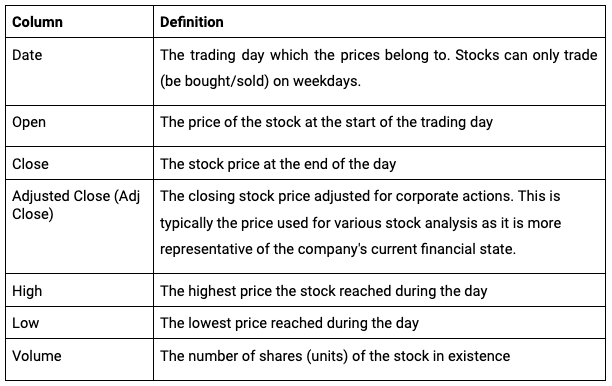

<a id="Link"></a>
## 9. Link to Notebook

GitHub repo can be found at: https://github.com/chubbypanda121/predictive_analytics_individual